In [321]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [322]:
data = pd.read_excel('dtsurat.xlsx')

In [323]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import normalize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import re, string, unicodedata
from string import punctuation
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Activation, Dropout, Input
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPool1D
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.probability import FreqDist


In [324]:
data['judul_surat']

0              Surat Keterangan sebagai Dosen Pembimbing
1        Surat Tugas LKTIA - Dr. Fitri Indriani, M.Pd.I.
2                              Surat Tugas LKMM Menengah
3                   Surat Tugas Kegiatan Tanggap Bencana
4           Surat Tugas Tim Piket Posko Tanggep Bencana 
                             ...                        
96          Surat Permohonan Pasang Iklan Lowongan - UAD
97         Surat Permohonan Beasiswa Karya FSBK Mei 2022
98                     Surat Permintaan Barang - BEM UAD
99                         Surat Permohonan Kepengurusan
100    Surat Permohonan Penerbitan SK Kepengurusan BE...
Name: judul_surat, Length: 101, dtype: object

In [325]:
#case folding
data['judul_surat'] = data['judul_surat'].str.lower()


print('Case Folding Result : \n')
print(data['judul_surat'].head(5))
print('\n\n\n')

Case Folding Result : 

0          surat keterangan sebagai dosen pembimbing
1    surat tugas lktia - dr. fitri indriani, m.pd.i.
2                          surat tugas lkmm menengah
3               surat tugas kegiatan tanggap bencana
4       surat tugas tim piket posko tanggep bencana 
Name: judul_surat, dtype: object






In [326]:
def remove_special(text):
    # remove tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # remove non ASCII (emoticon, chinese word, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    # remove mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z]+.-)|(\w+:\/\/\S+.-)"," ", text).split())
    # remove incomplete URL
    return text.replace("http://", " ").replace("https://", " ")

data['judul_surat'] = data['judul_surat'].apply(remove_special)

#remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

data['judul_surat'] = data['judul_surat'].apply(remove_punctuation)

#remove whitespace leading & trailing
def remove_whitespace_LT(text):
    return text.strip()

data['judul_surat'] = data['judul_surat'].apply(remove_whitespace_LT)

#remove multiple whitespace into single whitespace
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

data['judul_surat'] = data['judul_surat'].apply(remove_whitespace_multiple)

# remove single char
def remove_singl_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

data['judul_surat'] = data['judul_surat'].apply(remove_singl_char)

# NLTK word rokenize 
def word_tokenize_wrapper(text):
    return word_tokenize(text)

data['judul_surat_tokens'] = data['judul_surat'].apply(word_tokenize_wrapper)

print('Tokenizing Result : \n') 
print(data['judul_surat_tokens'].head())
print('\n\n\n')

Tokenizing Result : 

0      [surat, keterangan, sebagai, dosen, pembimbing]
1     [surat, tugas, lktia, dr, fitri, indriani, mpdi]
2                       [surat, tugas, lkmm, menengah]
3           [surat, tugas, kegiatan, tanggap, bencana]
4    [surat, tugas, tim, piket, posko, tanggep, ben...
Name: judul_surat_tokens, dtype: object






In [327]:
def freqDist_wrapper(text):
    return FreqDist(text)

data['judul_tokens_fdist'] = data['judul_surat_tokens'].apply(freqDist_wrapper)

print('Frequency Tokens : \n') 
print(data['judul_tokens_fdist'].head().apply(lambda x : x.most_common()))

Frequency Tokens : 

0    [(surat, 1), (keterangan, 1), (sebagai, 1), (d...
1    [(surat, 1), (tugas, 1), (lktia, 1), (dr, 1), ...
2    [(surat, 1), (tugas, 1), (lkmm, 1), (menengah,...
3    [(surat, 1), (tugas, 1), (kegiatan, 1), (tangg...
4    [(surat, 1), (tugas, 1), (tim, 1), (piket, 1),...
Name: judul_tokens_fdist, dtype: object


In [328]:
# ----------------------- get stopword from NLTK stopword -------------------------------
# get stopword indonesia
list_stopwords = stopwords.words('indonesian')


# ---------------------------- manualy add stopword  ------------------------------------
# append additional stopword
list_stopwords.extend(["yg", "dg", "rt", "dgn", "ny", "d", 'klo', 
                       'kalo', 'amp', 'biar', 'bikin', 'bilang', 
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih', 
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya', 
                       'jd', 'jgn', 'sdh', 'aja', 'n', 't', 
                       'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt',
                       '&amp', 'yah'])

# ----------------------- add stopword from txt file ------------------------------------
# read txt stopword using pandas
txt_stopword = pd.read_csv("stopword.txt", names= ["stopwords"], header = None)

# convert stopword string to list & append additional stopword
list_stopwords.extend(txt_stopword["stopwords"][0].split(' '))

# ---------------------------------------------------------------------------------------

# convert list to dictionary
list_stopwords = set(list_stopwords)


#remove stopword pada list token
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

data['judul_tokens_WSW'] = data['judul_surat_tokens'].apply(stopwords_removal) 


print(data['judul_tokens_WSW'].head())

0               [surat, keterangan, dosen, pembimbing]
1         [surat, tugas, lktia, fitri, indriani, mpdi]
2                       [surat, tugas, lkmm, menengah]
3           [surat, tugas, kegiatan, tanggap, bencana]
4    [surat, tugas, tim, piket, posko, tanggep, ben...
Name: judul_tokens_WSW, dtype: object


In [329]:
# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# stemmed
def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

for document in data['judul_tokens_WSW']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '
            
print(len(term_dict))
print("------------------------")

for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    print(term,":" ,term_dict[term])
    
print(term_dict)
print("------------------------")


# apply stemmed term to dataframe
def get_stemmed_term(document):
    return [term_dict[term] for term in document]

data['judul_tokens_stemmed'] = data['judul_tokens_WSW'].apply(get_stemmed_term)
print(data['judul_tokens_stemmed'])

230
------------------------
surat : surat
keterangan : terang
dosen : dosen
pembimbing : bimbing
tugas : tugas
lktia : lktia
fitri : fitri
indriani : indriani
mpdi : mpdi
lkmm : lkmm
menengah : tengah
kegiatan : giat
tanggap : tanggap
bencana : bencana
tim : tim
piket : piket
posko : posko
tanggep : tanggep
permohonan : mohon
izin : izin
uad : uad
awards : awards
bidang : bidang
kemahasiswaan : mahasiswa
alumni : alumni
pelatihan : latih
pembinaan : bina
kbmk : kbmk
2021 : 2021
lidm : lidm
php2d : php2d
bem : bem
fti : fti
imm : imm
farmasi : farmasi
umm : umm
championship : championship
pencak : pencak
silat : silat
virtual : virtual
panitia : panitia
por : por
bapomi : bapomi
diy : diy
lomba : lomba
11th : 11th
airlangga : airlangga
tapak : tapak
suci : suci
international : international
open : open
bakti : bakti
formica : formica
bangsa : bangsa
sosialisasi : sosialisasi
anti : anti
intoleransi : intoleransi
kekerasan : keras
seksual : seksual
perundungan : rundung
tahap : tahap
ko

In [330]:
data.to_csv("Text_Preprocessing.csv")

In [331]:
surat_data = pd.read_csv("Text_Preprocessing.csv", usecols=["nilai_bobot", "judul_tokens_stemmed"])
surat_data.columns = ["nilai_bobot", "judul_surat"]

surat_data.head()

,nilai_bobot,judul_surat
0,2,"['surat', 'terang', 'dosen', 'bimbing']"
1,1,"['surat', 'tugas', 'lktia', 'fitri', 'indriani..."
2,1,"['surat', 'tugas', 'lkmm', 'tengah']"
3,1,"['surat', 'tugas', 'giat', 'tanggap', 'bencana']"
4,1,"['surat', 'tugas', 'tim', 'piket', 'posko', 't..."


In [332]:
# join list of token as single document string
import ast

def join_text_list(texts):
    texts = ast.literal_eval(texts)
    return ' '.join([text for text in texts])
surat_data["data_join"] = surat_data["judul_surat"].apply(join_text_list)

surat_data["data_join"].head()

0                     surat terang dosen bimbing
1          surat tugas lktia fitri indriani mpdi
2                        surat tugas lkmm tengah
3               surat tugas giat tanggap bencana
4    surat tugas tim piket posko tanggep bencana
Name: data_join, dtype: object

In [333]:
# banyaknya term yang akan digunakan, 
# di pilih berdasarkan top max_features 
# yang diurutkan berdasarkan term frequency seluruh corpus
max_features = 1000

# Feature Engineering 
print ("------- TF-IDF on Surat Data -------")

tf_idf = TfidfVectorizer(max_features=max_features, binary=True)
tfidf_mat = tf_idf.fit_transform(surat_data["data_join"]).toarray()

print("TF-IDF ", type(tfidf_mat), tfidf_mat.shape)

------- TF-IDF on Surat Data -------
TF-IDF  <class 'numpy.ndarray'> (101, 220)


In [334]:
terms = tf_idf.get_feature_names_out()

# sum tfidf frequency of each term through documents
sums = tfidf_mat.sum(axis=0)

# connecting term to its sums frequency
termdata = []
for col, term in enumerate(terms):
    termdata.append((term, sums[col] ))

ranking = pd.DataFrame(termdata, columns=['term','weight'])
ranking.sort_values('weight', ascending=False)

,term,weight
188,surat,12.509422
155,pinjam,10.712517
28,bem,9.161741
208,uad,9.029029
205,tugas,8.744878
...,...,...
41,competition,0.333165
135,much,0.333165
216,walisongo,0.333165
174,saifuddin,0.333165


In [335]:
surat_data

,nilai_bobot,judul_surat,data_join
0,2,"['surat', 'terang', 'dosen', 'bimbing']",surat terang dosen bimbing
1,1,"['surat', 'tugas', 'lktia', 'fitri', 'indriani...",surat tugas lktia fitri indriani mpdi
2,1,"['surat', 'tugas', 'lkmm', 'tengah']",surat tugas lkmm tengah
3,1,"['surat', 'tugas', 'giat', 'tanggap', 'bencana']",surat tugas giat tanggap bencana
4,1,"['surat', 'tugas', 'tim', 'piket', 'posko', 't...",surat tugas tim piket posko tanggep bencana
...,...,...,...
96,0,"['surat', 'mohon', 'pasang', 'iklan', 'lowong'...",surat mohon pasang iklan lowong uad
97,0,"['surat', 'mohon', 'beasiswa', 'karya', 'fsbk'...",surat mohon beasiswa karya fsbk mei 2022
98,0,"['surat', 'minta', 'barang', 'bem', 'uad']",surat minta barang bem uad
99,0,"['surat', 'mohon', 'urus']",surat mohon urus


In [336]:
category = pd.get_dummies(surat_data['nilai_bobot'])
df_baru = pd.concat([surat_data, category], axis=1)
df_baru = df_baru.drop(columns='nilai_bobot')
df_baru

,judul_surat,data_join,0,1,2
0,"['surat', 'terang', 'dosen', 'bimbing']",surat terang dosen bimbing,0,0,1
1,"['surat', 'tugas', 'lktia', 'fitri', 'indriani...",surat tugas lktia fitri indriani mpdi,0,1,0
2,"['surat', 'tugas', 'lkmm', 'tengah']",surat tugas lkmm tengah,0,1,0
3,"['surat', 'tugas', 'giat', 'tanggap', 'bencana']",surat tugas giat tanggap bencana,0,1,0
4,"['surat', 'tugas', 'tim', 'piket', 'posko', 't...",surat tugas tim piket posko tanggep bencana,0,1,0
...,...,...,...,...,...
96,"['surat', 'mohon', 'pasang', 'iklan', 'lowong'...",surat mohon pasang iklan lowong uad,1,0,0
97,"['surat', 'mohon', 'beasiswa', 'karya', 'fsbk'...",surat mohon beasiswa karya fsbk mei 2022,1,0,0
98,"['surat', 'minta', 'barang', 'bem', 'uad']",surat minta barang bem uad,1,0,0
99,"['surat', 'mohon', 'urus']",surat mohon urus,1,0,0


In [337]:
df_baru.columns

Index(['judul_surat', 'data_join', 0, 1, 2], dtype='object')

In [338]:
judul = df_baru['data_join'].values
label = df_baru[[0,1,2]].values

In [339]:
label

array([[0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1,

In [340]:
count = data['nilai_bobot'].value_counts()
count

1    54
0    44
2     3
Name: nilai_bobot, dtype: int64

In [341]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [342]:
X_train, X_test, y_train, y_test = train_test_split(judul,label,test_size=0.2)

In [343]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train) 
# tokenizer.fit_on_texts(X_test)
 
sekuens_latih = tokenizer.texts_to_sequences(X_train)
sekuens_test = tokenizer.texts_to_sequences(X_test)

maxlen = 100
padded_latih = pad_sequences(sekuens_latih,  padding='post', maxlen=maxlen) 
padded_test = pad_sequences(sekuens_test,  padding='post', maxlen=maxlen)

In [344]:
vocab_size = len(tokenizer.word_index) + 1

In [345]:
vocab_size

202

In [346]:
padded_latih.shape

(80, 100)

In [347]:
padded_test.shape

(21, 100)

In [348]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn import metrics

In [349]:
knn = KNeighborsClassifier(n_neighbors=5, metric = 'minkowski', p = 2)
knn.fit(padded_latih,y_train)

KNeighborsClassifier()

In [351]:
knn.predict(padded_test)

array([[0, 1, 0],
       [0, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=uint8)

In [352]:
knn.score(padded_test,y_test)

0.8095238095238095

In [353]:
y_pred = knn.predict(padded_test)
y_true = y_test

In [354]:
cm = confusion_matrix(np.asarray(y_true).argmax(axis=1), np.asarray(y_pred).argmax(axis=1))

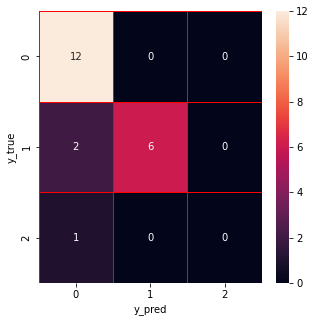

[[12  0  0]
 [ 2  6  0]
 [ 1  0  0]]


In [355]:
import seaborn as sns 
f, ax =plt.subplots(figsize = (5,5))
sns.heatmap(cm,annot = True, linewidths= 0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()
print(cm)

In [356]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true,y_pred)

0.8095238095238095

In [357]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85        12
           1       1.00      0.75      0.86         8
           2       0.00      0.00      0.00         1

   micro avg       0.85      0.81      0.83        21
   macro avg       0.60      0.56      0.57        21
weighted avg       0.83      0.81      0.81        21
 samples avg       0.81      0.81      0.81        21



C:\Users\Zidan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Zidan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
